In [53]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [55]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [56]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [57]:
tf.keras.backend.clear_session()

In [58]:
subject = 'Rio De Janeiro - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [59]:
data = pd.read_csv('2003_mo_model_input_RJ.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Rio De Janeiro - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego
0,2003-1,0.291137,12454.864800,3.675288e+07,254.362,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512
1,2003-2,0.293538,12574.990185,3.674675e+07,252.842,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332
2,2003-3,0.295914,12687.426111,3.674063e+07,229.385,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152
3,2003-4,0.298264,12814.530039,3.673451e+07,243.407,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971
4,2003-5,0.300588,12915.463832,3.672839e+07,256.535,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,41155.899192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,41127.312621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,41085.437504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,40981.162673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


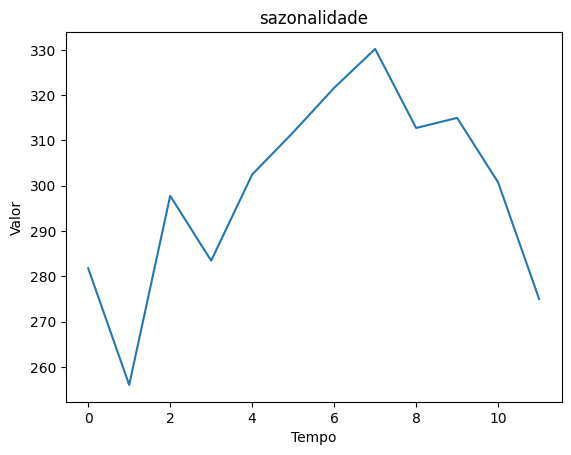

,sazonalidade
sazonalidade,
0,281.787783
1,256.037383
2,297.774940
3,283.460373
4,302.478384
5,311.794884
6,321.608097
7,330.208811
8,312.754725


In [60]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [61]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio de-01eiro - value,Rio de Janeiro- custo m2 (R$),Rio de Janeiro - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Rio de Janeiro - Desemprego,sazonalidade,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,12454.864800,3.675288e+07,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,8.356512,281.787783,254.362
1,2003-2,0.293538,12574.990185,3.674675e+07,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.350332,256.037383,252.842
2,2003-3,0.295914,12687.426111,3.674063e+07,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,8.344152,297.774940,229.385
3,2003-4,0.298264,12814.530039,3.673451e+07,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,8.337971,283.460373,243.407
4,2003-5,0.300588,12915.463832,3.672839e+07,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,8.331791,302.478384,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,41155.899192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302.478384,NaN
245,2023-6,NaN,41127.312621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.794884,NaN
246,2023-7,NaN,41085.437504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321.608097,NaN
247,2023-8,NaN,40981.162673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,330.208811,NaN


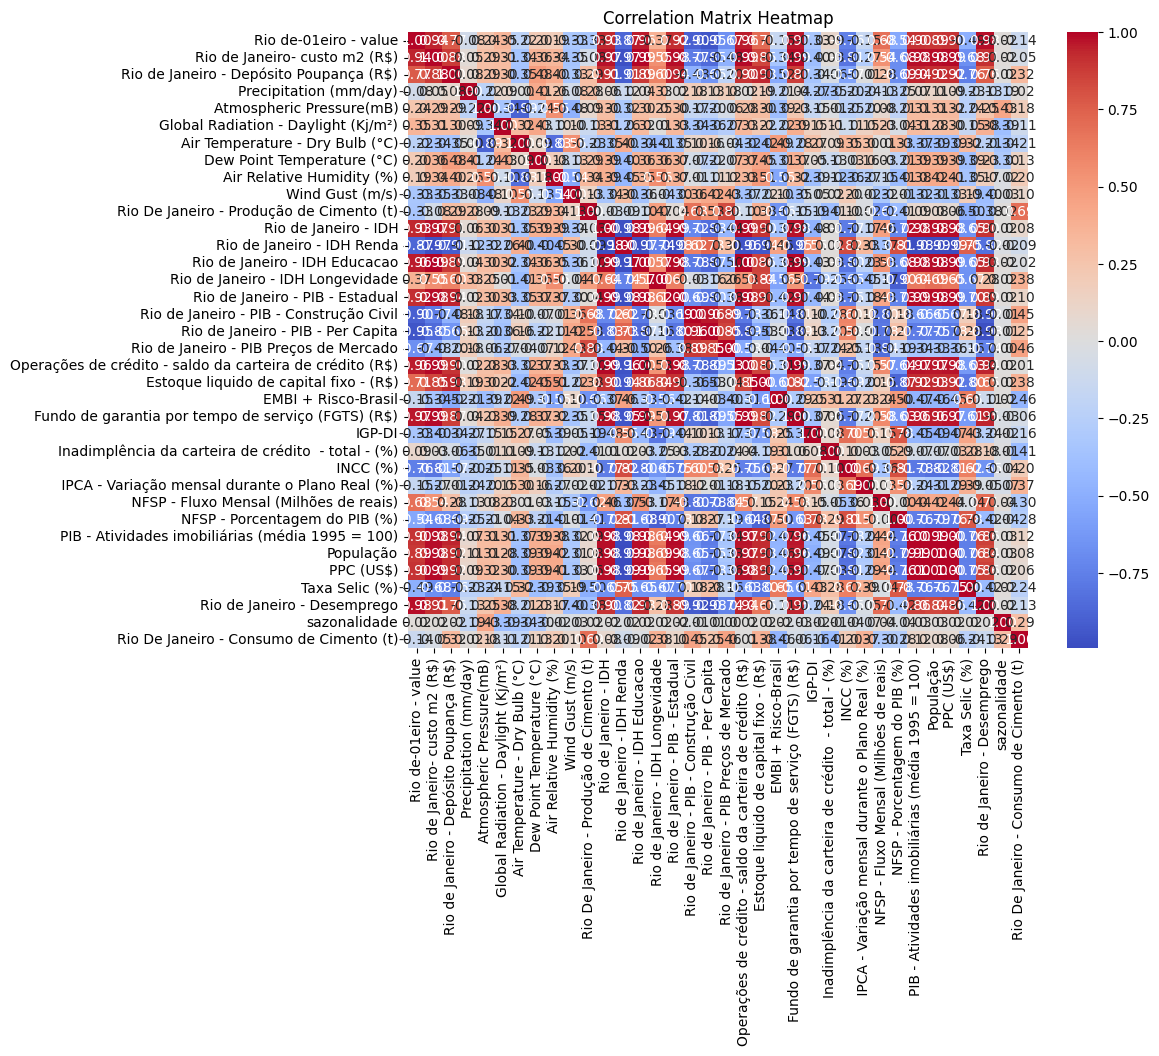

In [62]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [63]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)',
                 'PPC (US$)',
                 'População',
                 'Rio de Janeiro- custo m2 (R$)',
                 'Rio de Janeiro - Depósito Poupança (R$)', 
                 'sazonalidade'], axis=1)
data

,Unnamed: 0,Rio de-01eiro - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),Taxa Selic (%),Rio de Janeiro - Desemprego,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,2.829159,1010.529618,77.778706,0.280924,199.081280,0.773489,0.805095,0.731110,0.804160,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,11.520143,126.459809,1.611498,8.356512,254.362
1,2003-2,0.293538,2.243689,1011.819551,77.559351,0.437013,198.561780,0.773547,0.804751,0.731248,0.804513,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,11.189862,126.581813,1.450389,8.350332,252.842
2,2003-3,0.295914,1.817902,1012.695061,78.925026,0.552353,198.773336,0.773606,0.804407,0.731386,0.804866,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,10.820792,126.703818,1.870184,8.344152,229.385
3,2003-4,0.298264,1.641760,1013.728874,78.677330,0.640631,198.753800,0.773665,0.804063,0.731524,0.805218,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,10.417840,126.825822,1.355287,8.337971,243.407
4,2003-5,0.300588,1.281770,1014.834769,78.556857,0.712532,198.721455,0.773724,0.803719,0.731662,0.805571,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,9.959690,126.976217,1.585538,8.331791,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio de-01eiro - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),Taxa Selic (%),Rio de Janeiro - Desemprego
0,-1.533996,0.775020,-0.864677,-0.075433,-3.656745,-1.060779,-1.723389,2.130500,-1.581892,-3.073767,-1.790542,0.136347,0.121226,-1.445055,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,4.398348,-1.873379,2.132459,-0.790925
1,-1.486609,0.211775,-0.279582,-0.106182,-2.634518,-1.079132,-1.706702,2.098653,-1.569493,-2.991643,-1.768299,0.149077,0.152115,-1.365321,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,4.222509,-1.868164,1.592202,-0.794037
2,-1.439709,-0.197847,0.117537,0.085260,-1.879151,-1.071658,-1.690015,2.066806,-1.557094,-2.909519,-1.746055,0.161806,0.183005,-1.285587,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,4.026019,-1.862949,2.999926,-0.797148
3,-1.393318,-0.367303,0.586460,0.050537,-1.301019,-1.072349,-1.673328,2.034959,-1.544695,-2.827395,-1.723811,0.174535,0.213895,-1.205853,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,3.811492,-1.857734,1.273293,-0.800259
4,-1.347462,-0.713627,1.088078,0.033649,-0.830139,-1.073491,-1.656642,2.003111,-1.532296,-2.745271,-1.701567,0.187264,0.244784,-1.126118,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,3.567576,-1.851305,2.045407,-0.803370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.438978,-0.468897,0.787983,-0.525827,-0.696631,-0.476880,0.839598,-1.115007,1.321162,-0.586305,1.110414,-1.635096,-1.325228,-1.036232,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,-0.572934,1.406756,-1.311366,1.324172
188,1.443990,-0.230329,0.245695,-0.650783,-0.514316,-0.460898,0.793634,-1.106331,1.309803,-0.666909,1.098172,-1.625552,-1.326867,-1.053116,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,-0.588777,1.428132,-1.417143,1.322796
189,1.457014,0.085560,-0.048798,-0.804007,-0.330804,-0.421271,0.747671,-1.097656,1.298443,-0.747513,1.085930,-1.616009,-1.328507,-1.070000,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,-0.612606,1.449507,-1.597784,1.321421
190,1.470138,0.428083,-0.362841,-0.958655,-0.105169,-0.402090,0.701707,-1.088981,1.287084,-0.828116,1.073688,-1.606465,-1.330147,-1.086883,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,-0.640956,1.463901,-1.400787,1.320046


In [65]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      256.494
1      214.974
2      273.646
3      238.045
4      254.860
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 249, dtype: float64

In [66]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio de-01eiro - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),Taxa Selic (%),Rio de Janeiro - Desemprego
0,-1.533996,0.775020,-0.864677,-0.075433,-3.656745,-1.060779,-1.723389,2.130500,-1.581892,-3.073767,-1.790542,0.136347,0.121226,-1.445055,-1.361787,-2.389042,-0.582420,-1.347324,3.890153,1.258423,3.122582,2.723741,4.398348,-1.873379,2.132459,-0.790925
1,-1.486609,0.211775,-0.279582,-0.106182,-2.634518,-1.079132,-1.706702,2.098653,-1.569493,-2.991643,-1.768299,0.149077,0.152115,-1.365321,-1.361224,-2.352139,-0.799075,-1.380245,3.551840,1.252755,2.970356,2.350880,4.222509,-1.868164,1.592202,-0.794037
2,-1.439709,-0.197847,0.117537,0.085260,-1.879151,-1.071658,-1.690015,2.066806,-1.557094,-2.909519,-1.746055,0.161806,0.183005,-1.285587,-1.361187,-2.315236,-0.618584,-1.392954,3.391423,1.251338,2.869895,2.123016,4.026019,-1.862949,2.999926,-0.797148
3,-1.393318,-0.367303,0.586460,0.050537,-1.301019,-1.072349,-1.673328,2.034959,-1.544695,-2.827395,-1.723811,0.174535,0.213895,-1.205853,-1.360756,-2.278333,-0.139520,-1.396056,3.135979,1.249134,2.773628,2.021477,3.811492,-1.857734,1.273293,-0.800259
4,-1.347462,-0.713627,1.088078,0.033649,-0.830139,-1.073491,-1.656642,2.003111,-1.532296,-2.745271,-1.701567,0.187264,0.244784,-1.126118,-1.359394,-2.241431,0.494336,-1.388786,2.955412,1.238186,2.977624,1.887113,3.567576,-1.851305,2.045407,-0.803370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.395833,0.340356,-0.273398,0.343806,-0.556221,-1.418673,1.438456,-1.315781,1.334541,1.342289,1.098176,-1.500012,-1.660268,-1.692180,1.335787,0.819304,0.961603,1.338424,-1.233012,0.749349,-0.883659,-0.214006,-0.607704,0.952667,0.043807,1.473338
158,1.389960,-0.167711,0.323190,0.487223,-0.897291,-1.470839,1.429097,-1.308920,1.338981,1.290045,1.105247,-1.521309,-1.646368,-1.657425,1.325546,0.808136,1.030624,1.300351,-1.299304,0.977327,-0.950771,-0.434717,-0.620523,0.954843,0.210856,1.467585
159,1.384722,-0.540479,0.796678,0.471151,-1.091838,-1.532363,1.419738,-1.302059,1.343421,1.237801,1.112318,-1.542605,-1.632469,-1.622671,1.315396,0.796969,1.039183,1.250508,-1.248662,1.048267,-1.028465,-0.524091,-0.631530,0.957019,0.107070,1.461833
160,1.379646,-0.598926,1.239359,0.499512,-1.087726,-1.608317,1.410379,-1.295198,1.347861,1.185557,1.119389,-1.563902,-1.618570,-1.587917,1.306664,0.785801,1.017171,1.240363,-1.068274,1.048868,-1.103668,-0.614500,-0.640320,0.956331,0.392942,1.456081


In [67]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      256.494
1      214.974
2      273.646
3      238.045
4      254.860
        ...   
157    175.917
158    208.629
159    181.933
160    187.947
161    181.556
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 162, dtype: float64

In [68]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [69]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 26)

In [70]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio de-01eiro - value,Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - IDH Renda,Rio de Janeiro - IDH Educacao,Rio de Janeiro - IDH Longevidade,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),Taxa Selic (%),Rio de Janeiro - Desemprego
126,0.575814,-0.562201,1.236507,0.500961,-0.444330,0.995998,0.797097,-0.734365,0.652210,0.327520,0.862422,-0.029106,-0.391329,0.186886,0.722924,0.944085,-0.882533,0.551812,-0.368821,-0.155884,0.045243,0.888984,-0.460555,0.913820,-1.048761,0.731632
127,0.620950,-0.519854,0.889148,0.364433,-0.395212,0.926846,0.824296,-0.723171,0.676753,0.299252,0.875882,-0.083792,-0.444296,0.111052,0.745258,0.947319,-0.815413,0.566622,-0.328087,-0.349984,0.061828,0.954254,-0.440372,0.923198,-0.649312,0.766827
128,0.671632,-0.399748,0.313103,0.407645,-0.376205,0.836461,0.851494,-0.711978,0.701296,0.270984,0.889342,-0.138478,-0.497262,0.035217,0.767990,0.950553,-0.745839,0.568617,-0.176031,-0.529294,0.046225,1.045217,-0.419247,0.932576,-0.535369,0.802021
129,0.720432,-0.284296,-0.102129,0.309589,-0.331572,0.767757,0.878692,-0.700784,0.725838,0.242716,0.902802,-0.193163,-0.550229,-0.040617,0.799035,0.953786,-0.687348,0.719776,-0.113037,-0.788101,0.032522,1.176395,-0.397019,0.941953,-1.288807,0.837216
130,0.766028,-0.137200,-0.519970,0.093186,-0.207908,0.681375,0.905890,-0.689590,0.750381,0.214448,0.916261,-0.247849,-0.603195,-0.116452,0.830824,0.957020,-0.639220,0.905478,-0.022703,-1.020394,0.042757,1.303259,-0.376532,0.942711,-1.507550,0.872410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.438978,-0.468897,0.787983,-0.525827,-0.696631,-0.476880,0.839598,-1.115007,1.321162,-0.586305,1.110414,-1.635096,-1.325228,-1.036232,1.316363,0.389193,-0.244459,1.237409,0.589021,-0.685819,-1.749976,-2.010387,-0.572934,1.406756,-1.311366,1.324172
188,1.443990,-0.230329,0.245695,-0.650783,-0.514316,-0.460898,0.793634,-1.106331,1.309803,-0.666909,1.098172,-1.625552,-1.326867,-1.053116,1.330590,0.370392,-0.199028,1.214214,1.043728,-0.770458,-1.593005,-1.870713,-0.588777,1.428132,-1.417143,1.322796
189,1.457014,0.085560,-0.048798,-0.804007,-0.330804,-0.421271,0.747671,-1.097656,1.298443,-0.747513,1.085930,-1.616009,-1.328507,-1.070000,1.352241,0.351592,-0.173807,1.409043,1.387010,-0.910077,-1.351489,-1.806230,-0.612606,1.449507,-1.597784,1.321421
190,1.470138,0.428083,-0.362841,-0.958655,-0.105169,-0.402090,0.701707,-1.088981,1.287084,-0.828116,1.073688,-1.606465,-1.330147,-1.086883,1.370978,0.332791,-0.169867,1.654237,1.815728,-1.020687,-1.198492,-1.727496,-0.640956,1.463901,-1.400787,1.320046


In [71]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 26)

In [72]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [73]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    train, train_val = validation_splitter(train_input, 7)
    target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train, 
                        target, 
                        epochs=10000,
                        validation_data=(train_val,
                                         target_val),
#                         validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [74]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [75]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1887070992, 914038337, 2469965215, 2804323677, 1848041467]


Step: 0 ___________________________________________
val_loss: 723.7523803710938
winner_seed: 1887070992


Step: 1 ___________________________________________
val_loss: 702.9825439453125
winner_seed: 914038337


Step: 2 ___________________________________________
val_loss: 827.6587524414062


Step: 3 ___________________________________________
val_loss: 857.85693359375


Step: 4 ___________________________________________
val_loss: 887.271240234375


final_seed: 914038337


In [76]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 188ms/step - loss: 122814.9453 - val_loss: 99098.6797
Epoch 2/10000
4/4 [==============================] - 0s 16ms/step - loss: 86511.0703 - val_loss: 57313.9961
Epoch 3/10000
4/4 [==============================] - 0s 17ms/step - loss: 49750.1250 - val_loss: 32887.2734
Epoch 4/10000
4/4 [==============================] - 0s 16ms/step - loss: 28832.1465 - val_loss: 20140.5039
Epoch 5/10000
4/4 [==============================] - 0s 16ms/step - loss: 17749.4980 - val_loss: 13012.1182
Epoch 6/10000
4/4 [==============================] - 0s 14ms/step - loss: 11471.4053 - val_loss: 8948.4443
Epoch 7/10000
4/4 [==============================] - 0s 15ms/step - loss: 7872.2124 - val_loss: 6883.2192
Epoch 8/10000
4/4 [==============================] - 0s 16ms/step - loss: 6020.8096 - val_loss: 5889.9805
Epoch 9/10000
4/4 [==============================] - 0s 17ms/step - loss: 5057.2256 - val_loss: 5269.7476
Epoch 10/10000
4/4 [=============

4/4 [==============================] - 0s 12ms/step - loss: 3872.9204 - val_loss: 4837.3735
Epoch 78/10000
4/4 [==============================] - 0s 14ms/step - loss: 3869.0479 - val_loss: 4826.3320
Epoch 79/10000
4/4 [==============================] - 0s 13ms/step - loss: 3866.5547 - val_loss: 4821.7505
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 3871.5107 - val_loss: 4823.8477
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 3866.2356 - val_loss: 4825.9443
Epoch 82/10000
4/4 [==============================] - 0s 15ms/step - loss: 3876.4124 - val_loss: 4831.3311
Epoch 83/10000
4/4 [==============================] - 0s 16ms/step - loss: 3869.9705 - val_loss: 4847.8271
Epoch 84/10000
4/4 [==============================] - 0s 13ms/step - loss: 3879.6128 - val_loss: 4847.7725
Epoch 85/10000
4/4 [==============================] - 0s 14ms/step - loss: 3870.3438 - val_loss: 4829.1284
Epoch 86/10000
4/4 [==============================] 

4/4 [==============================] - 0s 16ms/step - loss: 3770.1592 - val_loss: 4836.3545
Epoch 154/10000
4/4 [==============================] - 0s 17ms/step - loss: 3746.4468 - val_loss: 4840.6372
Epoch 155/10000
4/4 [==============================] - 0s 14ms/step - loss: 3763.3147 - val_loss: 4896.8237
Epoch 156/10000
4/4 [==============================] - 0s 13ms/step - loss: 3765.7952 - val_loss: 4856.1284
Epoch 157/10000
4/4 [==============================] - 0s 13ms/step - loss: 3785.8059 - val_loss: 4855.0054
Epoch 158/10000
4/4 [==============================] - 0s 13ms/step - loss: 3751.8552 - val_loss: 4858.0557
Epoch 159/10000
4/4 [==============================] - 0s 13ms/step - loss: 3752.5291 - val_loss: 4857.4297
Epoch 160/10000
4/4 [==============================] - 0s 13ms/step - loss: 3747.5847 - val_loss: 4855.3213
Epoch 161/10000
4/4 [==============================] - 0s 13ms/step - loss: 3755.0659 - val_loss: 4936.3032
Epoch 162/10000
4/4 [=======================

4/4 [==============================] - 0s 15ms/step - loss: 3681.6775 - val_loss: 4820.7236
Epoch 230/10000
4/4 [==============================] - 0s 16ms/step - loss: 3682.6631 - val_loss: 4836.2236
Epoch 231/10000
4/4 [==============================] - 0s 16ms/step - loss: 3669.0435 - val_loss: 4827.7622
Epoch 232/10000
4/4 [==============================] - 0s 16ms/step - loss: 3679.9238 - val_loss: 4818.2729
Epoch 233/10000
4/4 [==============================] - 0s 17ms/step - loss: 3677.2722 - val_loss: 4781.6187
Epoch 234/10000
4/4 [==============================] - 0s 17ms/step - loss: 3679.8936 - val_loss: 4852.1377
Epoch 235/10000
4/4 [==============================] - 0s 16ms/step - loss: 3676.6199 - val_loss: 4816.3296
Epoch 236/10000
4/4 [==============================] - 0s 17ms/step - loss: 3671.6692 - val_loss: 4825.9736
Epoch 237/10000
4/4 [==============================] - 0s 17ms/step - loss: 3696.2302 - val_loss: 4806.2466
Epoch 238/10000
4/4 [=======================

4/4 [==============================] - 0s 18ms/step - loss: 3651.7568 - val_loss: 4850.7085
Epoch 306/10000
4/4 [==============================] - 0s 16ms/step - loss: 3644.7051 - val_loss: 4854.3530
Epoch 307/10000
4/4 [==============================] - 0s 14ms/step - loss: 3650.4958 - val_loss: 4843.1338
Epoch 308/10000
4/4 [==============================] - 0s 16ms/step - loss: 3637.0457 - val_loss: 4857.9292
Epoch 309/10000
4/4 [==============================] - 0s 16ms/step - loss: 3692.3245 - val_loss: 4856.4746
Epoch 310/10000
4/4 [==============================] - 0s 17ms/step - loss: 3684.5215 - val_loss: 4906.5112
Epoch 311/10000
4/4 [==============================] - 0s 16ms/step - loss: 3669.9692 - val_loss: 4890.1650
Epoch 312/10000
4/4 [==============================] - 0s 16ms/step - loss: 3653.9080 - val_loss: 4885.0586
Epoch 313/10000
4/4 [==============================] - 0s 17ms/step - loss: 3665.2573 - val_loss: 4826.8628
Epoch 314/10000
4/4 [=======================

4/4 [==============================] - 0s 16ms/step - loss: 1116.6323 - val_loss: 1578.4409
Epoch 382/10000
4/4 [==============================] - 0s 15ms/step - loss: 1001.9294 - val_loss: 1545.3998
Epoch 383/10000
4/4 [==============================] - 0s 15ms/step - loss: 1043.0389 - val_loss: 1529.5710
Epoch 384/10000
4/4 [==============================] - 0s 16ms/step - loss: 1115.9985 - val_loss: 1588.5675
Epoch 385/10000
4/4 [==============================] - 0s 17ms/step - loss: 1035.2902 - val_loss: 1563.6383
Epoch 386/10000
4/4 [==============================] - 0s 16ms/step - loss: 1053.2878 - val_loss: 1538.7363
Epoch 387/10000
4/4 [==============================] - 0s 16ms/step - loss: 977.3616 - val_loss: 1554.3638
Epoch 388/10000
4/4 [==============================] - 0s 16ms/step - loss: 1048.3468 - val_loss: 1513.6626
Epoch 389/10000
4/4 [==============================] - 0s 16ms/step - loss: 1012.3444 - val_loss: 1533.6975
Epoch 390/10000
4/4 [========================

4/4 [==============================] - 0s 17ms/step - loss: 852.4647 - val_loss: 1435.4863
Epoch 458/10000
4/4 [==============================] - 0s 16ms/step - loss: 828.6694 - val_loss: 1435.0133
Epoch 459/10000
4/4 [==============================] - 0s 17ms/step - loss: 883.6649 - val_loss: 1475.4099
Epoch 460/10000
4/4 [==============================] - 0s 16ms/step - loss: 848.3979 - val_loss: 1590.4437
Epoch 461/10000
4/4 [==============================] - 0s 16ms/step - loss: 843.1741 - val_loss: 1441.2087
Epoch 462/10000
4/4 [==============================] - 0s 17ms/step - loss: 844.3128 - val_loss: 1417.6317
Epoch 463/10000
4/4 [==============================] - 0s 16ms/step - loss: 797.5511 - val_loss: 1410.8401
Epoch 464/10000
4/4 [==============================] - 0s 15ms/step - loss: 851.6690 - val_loss: 1450.8225
Epoch 465/10000
4/4 [==============================] - 0s 15ms/step - loss: 838.1896 - val_loss: 1447.8687
Epoch 466/10000
4/4 [==============================] 

4/4 [==============================] - 0s 16ms/step - loss: 387.8401 - val_loss: 1204.6136
Epoch 534/10000
4/4 [==============================] - 0s 17ms/step - loss: 500.6101 - val_loss: 995.7800
Epoch 535/10000
4/4 [==============================] - 0s 16ms/step - loss: 391.0555 - val_loss: 1637.3784
Epoch 536/10000
4/4 [==============================] - 0s 16ms/step - loss: 478.5838 - val_loss: 1576.9711
Epoch 537/10000
4/4 [==============================] - 0s 16ms/step - loss: 536.6301 - val_loss: 1005.0291
Epoch 538/10000
4/4 [==============================] - 0s 17ms/step - loss: 465.4152 - val_loss: 1138.5167
Epoch 539/10000
4/4 [==============================] - 0s 17ms/step - loss: 469.2805 - val_loss: 1088.5742
Epoch 540/10000
4/4 [==============================] - 0s 18ms/step - loss: 399.4752 - val_loss: 860.1964
Epoch 541/10000
4/4 [==============================] - 0s 15ms/step - loss: 434.3419 - val_loss: 1533.0161
Epoch 542/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 15ms/step - loss: 248.3135 - val_loss: 801.6697
Epoch 611/10000
4/4 [==============================] - 0s 18ms/step - loss: 252.6871 - val_loss: 1060.8982
Epoch 612/10000
4/4 [==============================] - 0s 15ms/step - loss: 263.1676 - val_loss: 828.9433
Epoch 613/10000
4/4 [==============================] - 0s 15ms/step - loss: 228.8443 - val_loss: 880.9503
Epoch 614/10000
4/4 [==============================] - 0s 17ms/step - loss: 237.6153 - val_loss: 1234.0555
Epoch 615/10000
4/4 [==============================] - 0s 17ms/step - loss: 277.9187 - val_loss: 878.2628
Epoch 616/10000
4/4 [==============================] - 0s 16ms/step - loss: 258.9426 - val_loss: 764.3676
Epoch 617/10000
4/4 [==============================] - 0s 15ms/step - loss: 246.5211 - val_loss: 752.8736
Epoch 618/10000
4/4 [==============================] - 0s 16ms/step - loss: 238.2559 - val_loss: 736.4545
Epoch 619/10000
4/4 [==============================] - 0s 15

4/4 [==============================] - 0s 15ms/step - loss: 235.4886 - val_loss: 1056.3933
Epoch 688/10000
4/4 [==============================] - 0s 15ms/step - loss: 208.5452 - val_loss: 975.9191
Epoch 689/10000
4/4 [==============================] - 0s 15ms/step - loss: 226.8653 - val_loss: 925.4741
Epoch 690/10000
4/4 [==============================] - 0s 16ms/step - loss: 202.6442 - val_loss: 1065.1702
Epoch 691/10000
4/4 [==============================] - 0s 16ms/step - loss: 210.3863 - val_loss: 968.4286
Epoch 692/10000
4/4 [==============================] - 0s 16ms/step - loss: 211.3095 - val_loss: 863.1838
Epoch 693/10000
4/4 [==============================] - 0s 14ms/step - loss: 180.4251 - val_loss: 842.1379
Epoch 694/10000
4/4 [==============================] - 0s 16ms/step - loss: 200.9872 - val_loss: 939.0168
Epoch 695/10000
4/4 [==============================] - 0s 17ms/step - loss: 195.0301 - val_loss: 878.9720
Epoch 696/10000
4/4 [==============================] - 0s 16

4/4 [==============================] - 0s 15ms/step - loss: 187.8850 - val_loss: 939.6653
Epoch 765/10000
4/4 [==============================] - 0s 15ms/step - loss: 172.4273 - val_loss: 884.4500
Epoch 766/10000
4/4 [==============================] - 0s 15ms/step - loss: 179.5701 - val_loss: 942.9984
Epoch 767/10000
4/4 [==============================] - 0s 15ms/step - loss: 184.1787 - val_loss: 944.2809
Epoch 768/10000
4/4 [==============================] - 0s 16ms/step - loss: 187.7911 - val_loss: 929.8984
Epoch 769/10000
4/4 [==============================] - 0s 16ms/step - loss: 172.2443 - val_loss: 842.9741
Epoch 770/10000
4/4 [==============================] - 0s 16ms/step - loss: 174.6886 - val_loss: 917.9026
Epoch 771/10000
4/4 [==============================] - 0s 16ms/step - loss: 161.7993 - val_loss: 888.8681
Epoch 772/10000
4/4 [==============================] - 0s 16ms/step - loss: 174.0557 - val_loss: 895.3455
Epoch 773/10000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 17ms/step - loss: 176.1663 - val_loss: 890.1944
Epoch 842/10000
4/4 [==============================] - 0s 16ms/step - loss: 178.8144 - val_loss: 880.8731
Epoch 843/10000
4/4 [==============================] - 0s 15ms/step - loss: 184.0474 - val_loss: 880.3511
Epoch 844/10000
4/4 [==============================] - 0s 17ms/step - loss: 159.7271 - val_loss: 893.8853
Epoch 845/10000
4/4 [==============================] - 0s 15ms/step - loss: 157.8142 - val_loss: 859.4668
Epoch 846/10000
4/4 [==============================] - 0s 16ms/step - loss: 162.9165 - val_loss: 861.6942
Epoch 847/10000
4/4 [==============================] - 0s 16ms/step - loss: 157.4357 - val_loss: 845.6712
Epoch 848/10000
4/4 [==============================] - 0s 15ms/step - loss: 165.8884 - val_loss: 842.1125
Epoch 849/10000
4/4 [==============================] - 0s 15ms/step - loss: 157.7128 - val_loss: 884.1575
Epoch 850/10000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 16ms/step - loss: 140.2477 - val_loss: 796.0316
Epoch 919/10000
4/4 [==============================] - 0s 16ms/step - loss: 153.6516 - val_loss: 819.1500
Epoch 920/10000
4/4 [==============================] - 0s 15ms/step - loss: 166.8913 - val_loss: 852.0837
Epoch 921/10000
4/4 [==============================] - 0s 15ms/step - loss: 148.9236 - val_loss: 835.5998
Epoch 922/10000
4/4 [==============================] - 0s 17ms/step - loss: 174.6151 - val_loss: 891.0264
Epoch 923/10000
4/4 [==============================] - 0s 15ms/step - loss: 150.3252 - val_loss: 839.0180
Epoch 924/10000
4/4 [==============================] - 0s 16ms/step - loss: 145.2150 - val_loss: 826.8224
Epoch 925/10000
4/4 [==============================] - 0s 16ms/step - loss: 155.9057 - val_loss: 881.6954
Epoch 926/10000
4/4 [==============================] - 0s 16ms/step - loss: 145.3630 - val_loss: 852.1920
Epoch 927/10000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 16ms/step - loss: 144.5761 - val_loss: 887.5314
Epoch 996/10000
4/4 [==============================] - 0s 16ms/step - loss: 149.3350 - val_loss: 940.2083
Epoch 997/10000
4/4 [==============================] - 0s 16ms/step - loss: 146.9602 - val_loss: 863.6490
Epoch 998/10000
4/4 [==============================] - 0s 15ms/step - loss: 137.4545 - val_loss: 858.0081
Epoch 999/10000
4/4 [==============================] - 0s 14ms/step - loss: 153.7958 - val_loss: 849.9500
Epoch 1000/10000
4/4 [==============================] - 0s 16ms/step - loss: 117.4381 - val_loss: 856.9581
Epoch 1001/10000
4/4 [==============================] - 0s 17ms/step - loss: 121.3415 - val_loss: 861.8779
Epoch 1002/10000
4/4 [==============================] - 0s 16ms/step - loss: 132.8377 - val_loss: 883.4481
Epoch 1003/10000
4/4 [==============================] - 0s 17ms/step - loss: 136.9169 - val_loss: 935.5291
Epoch 1004/10000
4/4 [==============================] - 0s

Epoch 1072/10000
4/4 [==============================] - 0s 15ms/step - loss: 126.8373 - val_loss: 946.3845
Epoch 1073/10000
4/4 [==============================] - 0s 16ms/step - loss: 131.7384 - val_loss: 871.0637
Epoch 1074/10000
4/4 [==============================] - 0s 16ms/step - loss: 119.8514 - val_loss: 945.9286
Epoch 1075/10000
4/4 [==============================] - 0s 15ms/step - loss: 142.9823 - val_loss: 991.2590
Epoch 1076/10000
4/4 [==============================] - 0s 15ms/step - loss: 121.1723 - val_loss: 936.3616
Epoch 1077/10000
4/4 [==============================] - 0s 15ms/step - loss: 134.0381 - val_loss: 906.4968
Epoch 1078/10000
4/4 [==============================] - 0s 16ms/step - loss: 118.6090 - val_loss: 983.8753
Epoch 1079/10000
4/4 [==============================] - 0s 16ms/step - loss: 146.1680 - val_loss: 933.8685
Epoch 1080/10000
4/4 [==============================] - 0s 17ms/step - loss: 148.6682 - val_loss: 935.7804
Epoch 1081/10000
4/4 [===============

In [77]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [78]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 18ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,200.735779,201.710846,197.939194,193.474854,190.504532,189.143585,188.547684,188.272736,188.212051,188.360718,189.420624,191.714783,198.727066,206.160355,204.754623,199.386108,194.04567,191.293839,190.101822,189.779007,190.225815,192.315613,200.380844,220.493378,240.537247,249.729324,252.572495,250.296906,244.592239,234.930527
Target,185.846,200.671,207.913,188.107,193.661,175.783,185.078,146.761,173.121,169.841,142.706,242.422,226.205,229.696,232.624,234.262,217.727,190.769,232.609,195.364,205.69,231.354,236.711,215.36,258.015,244.87,225.41,252.849,226.618,190.993
Error,14.889786,1.039841,9.973801,5.367859,3.156464,13.36058,3.469681,41.511734,15.091049,18.519714,46.71463,50.707214,27.477936,23.535645,27.86937,34.875885,23.681335,0.524841,42.507172,5.584991,15.464188,39.038391,36.330154,5.133377,17.477768,4.859329,27.162491,2.552094,17.974243,43.937531


In [79]:
display(mae)
display(mape)

20.659636

0.101756185

In [80]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [81]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-0: |Prediction[[2308.0374]] - Target[2211.91]| =  Error: [[96.12744]]; MAPE:[[0.04345902]]
1/1 [==============================] - 0s 17ms/step
Ano-0: |Prediction[[2377.6643]] - Target[2648.3710000000005]| =  Error: [[270.7068]]; MAPE:[[0.10221633]]
1/1 [==============================] - 0s 19ms/step
Ano-5: |Prediction[[1472.6588]] - Target[1398.7549999999999]| =  Error: [[73.90381]]; MAPE:[[0.05283542]]


[array([[96.12744]], dtype=float32),
 array([[270.7068]], dtype=float32),
 array([[73.90381]], dtype=float32)]

146.91267

0.06617026